# Semi-supervised synthetic data validation

### Importing necessary libraries

In [1]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2023-06-05 14:33:33.814148: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 14:33:33.862958: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 14:33:33.863868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 14:33:34.609909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [3]:
import pandas as pd

### Importing data

In [4]:
data=pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [5]:
data=data.drop(['DEATH_EVENT'],axis=1)

In [6]:
data[data.duplicated(keep=False)].shape[0]

0

In [7]:
np.random.seed(42)
data=data.sample(frac=1)

In [8]:
values= ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time','anaemia','diabetes','high_blood_pressure','sex','smoking']

In [9]:
data=data[values]

### UMAP on entire data

In [10]:
from fdc.fdc import feature_clustering

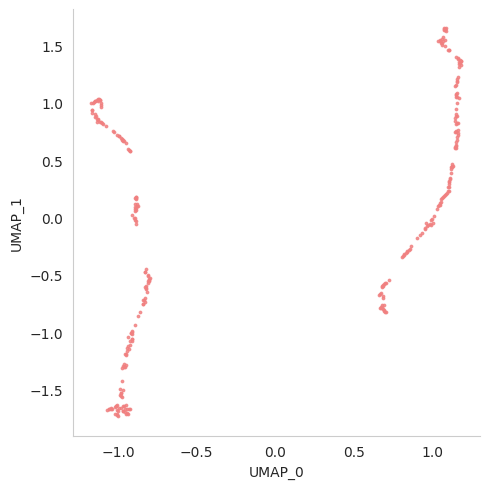

In [11]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

In [12]:
from fdc.clustering import Clustering

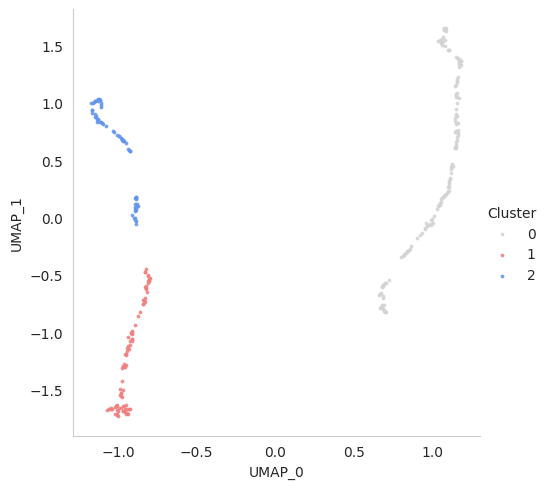

In [13]:
np.random.seed(42)
umap_clustering=Clustering(umap_emb,umap_emb,True)
umap_cluster_list,umap_cluster_counts=umap_clustering.K_means(3)

### Feature-type Distributed Clustering (FDC)

In [14]:
cont_list= ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']

ord_list= ['anaemia','diabetes','high_blood_pressure','sex','smoking']


FDC.normalize (init): 0.00001 / 0.000s
FDC.normalize (clustering CONT): 1.61076 / 1.611s
FDC.normalize (clustering ORD): 4.05407 / 5.665s
FDC.normalize (clustering NOM): 0.00009 / 5.665s
FDC.normalize (concat): 0.00003 / 5.665s
FDC.normalize (umap 5 -> 2): 1.65366 / 7.319s
FDC.normalize (array -> DataFrame): 0.00035 / 7.319s


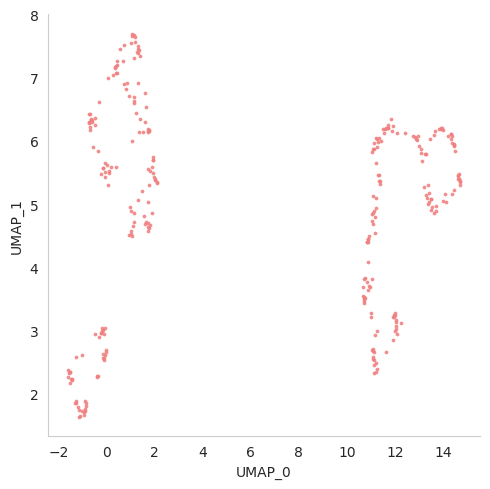

FDC.normalize (plotting): 0.59802 / 7.917s
FDC.normalize (array -> DataFrame): 0.00026 / 7.917s
FDC.normalize (total): 0.00001 / 7.917s


In [15]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

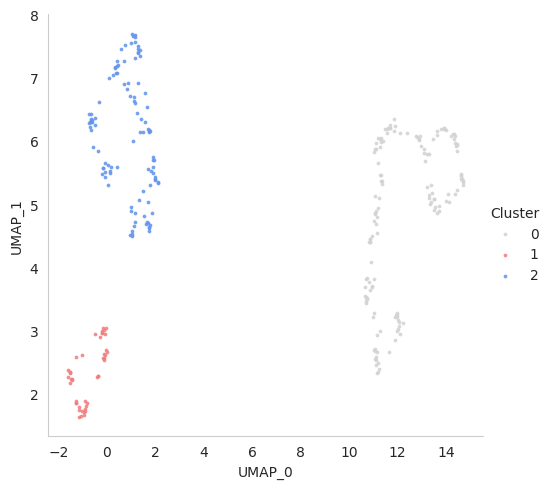

In [16]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

In [17]:
cluster_counts

array([146,  45, 108])

### Concatinating cluster labels as Target to original data

In [18]:
data["Target"]=cluster_list

In [19]:
data

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking,Target
281,70.000,582,40,51000.00,2.7,136,250,0,0,0,1,1,0
265,50.000,298,35,362000.00,0.9,140,240,1,0,0,1,1,1
164,45.000,2442,30,334000.00,1.1,139,129,0,1,0,1,0,2
9,80.000,123,35,388000.00,9.4,133,10,1,0,1,1,1,1
77,42.000,102,40,237000.00,1.2,140,74,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,60.667,151,40,201000.00,1.0,136,172,1,1,1,0,0,0
71,58.000,582,35,122000.00,0.9,139,71,0,1,0,1,1,0
106,55.000,748,45,263000.00,1.3,137,88,0,0,0,1,0,2
270,44.000,582,30,263358.03,1.6,130,244,0,1,1,1,1,2


### Train-val split

In [20]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
np.random.seed(42)
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(np.array(data.drop(["Target"],axis=1)), np.array(cluster_list), test_size = 0.25, random_state = 42)

### Gradient boosting classifier for original traing data (Model-1)

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
np.random.seed(42)
model_1 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=42)


In [22]:
from sklearn.model_selection import cross_val_score
score_lr=cross_val_score(model_1, train_features, train_labels,cv=5)
print(score_lr)
print("Avg :",np.average(score_lr))

[1.         1.         0.93333333 1.         1.        ]
Avg : 0.9866666666666667


In [23]:
model_1.fit(train_features,  train_labels)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           n_estimators=20, random_state=42)

### Preparing training data for synthetic data generation

In [24]:
train_features=pd.DataFrame(train_features)

In [25]:
train_features["Target"]=train_labels

In [26]:
train_features.to_csv('Heart_failure_training_daat(semi_sup).csv',index=False)

In [27]:
hold_out_set=pd.DataFrame(test_features)

In [28]:
hold_out_set["Target"]=test_labels

In [29]:
hold_out_set.to_csv('Heart_failure_hold_out_data_set(semi_sup).csv',index=False)

In [30]:
values= ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time','anaemia','diabetes','high_blood_pressure','sex','smoking','Target']

In [31]:
dicts = {}
for i in range(len(values)):
        dicts[values[i]]=i


In [32]:
train_features.rename(columns=dicts,inplace=True)


In [33]:
train_features

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,67.0,582.0,50.0,263358.03,1.18,137.0,76.0,0.0,0.0,0.0,1.0,1.0,2
1,45.0,2060.0,60.0,742000.00,0.80,138.0,278.0,0.0,1.0,0.0,0.0,0.0,1
2,53.0,446.0,60.0,263358.03,1.00,139.0,215.0,1.0,0.0,1.0,1.0,0.0,2
3,55.0,748.0,45.0,263000.00,1.30,137.0,88.0,0.0,0.0,0.0,1.0,0.0,2
4,70.0,81.0,35.0,533000.00,1.30,139.0,212.0,0.0,1.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,50.0,318.0,40.0,216000.00,2.30,131.0,60.0,0.0,0.0,1.0,0.0,0.0,0
220,65.0,56.0,25.0,237000.00,5.00,130.0,207.0,0.0,0.0,0.0,0.0,0.0,0
221,70.0,125.0,25.0,237000.00,1.00,140.0,15.0,1.0,0.0,1.0,0.0,0.0,0
222,68.0,577.0,25.0,166000.00,1.00,138.0,43.0,1.0,0.0,1.0,1.0,0.0,0


## NextConvGen

### FDC for searcing neighbors for synthetic data generation

In [34]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)
fdc = FDC()
fdc.cont_list =list(range(data.shape[1]))[0:7]
fdc.ord_list=list(range(data.shape[1]))[7:12]
fdc.nom_list=list(range(data.shape[1]))[12:]

In [35]:
train_features=np.array(train_features)

### Preapring and training NextConvGen model

In [36]:
gen = NextConvGeN(train_features.shape[1], neb=5, fdc=fdc)

In [37]:
gen.reset(train_features)

2023-06-05 14:33:55.806789: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [38]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)
gen.train(train_features)

FDC.normalize (init): 0.00001 / 0.000s
FDC.normalize (clustering CONT): 1.39833 / 1.398s
FDC.normalize (clustering ORD): 2.90744 / 4.306s
FDC.normalize (clustering NOM): 3.22020 / 7.526s
FDC.normalize (concat): 0.00011 / 7.526s
FDC.normalize (total): 0.00001 / 7.526s
|N| = (224, 5)
|D| = (224, 13)


2023-06-05 14:34:02.624566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [10,2]
	 [[{{node Placeholder/_3}}]]


1/1 [==============================] - 0s 109ms/step


2023-06-05 14:34:03.625532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


In [39]:
syn_train_data=gen.generateData(1000)

In [40]:
pd.DataFrame(syn_train_data)

### Generating 1000 synthetic points and randomly selecting the same legth of original training points for evaluation

In [41]:
from fdc.NN_models import *
np.random.seed(42)
syn_train_data = syn_data_gen(gen,1000,values)

In [42]:
syn_train_data['Target']

In [43]:
def balanced_synthetic_data(org_data,syn_data):
    import math
    org_data_len = org_data.shape[0]
    class_counts = org_data.iloc[:,-1].value_counts()
    column_names = list( syn_data.columns)
    df_list=[]
    for i in range(len(class_counts)):
        m = len(syn_data[syn_data['Target']==i])

        if m < class_counts[i]:
            run=math.ceil(class_counts[i]/m)
            syn_data = syn_data_gen(gen,org_data_len*run,values)
        c_i=syn_data[syn_data['Target']==i].sample(n=int(class_counts[i]),axis=0,random_state=42)
        df_list.append(c_i)
    balanced_df=pd.concat(df_list,names=column_names)
    return balanced_df

In [44]:
syn_train_data=balanced_synthetic_data(pd.DataFrame(train_features),syn_train_data)

In [45]:
syn_train_data['Target'].value_counts()

In [46]:
syn_train_data.to_csv('Heart_failure_NextConvGen_syn_data(semi_sup).csv',index=False)

In [47]:
np.random.seed(42)
syn_train_data=syn_train_data.sample(frac=1) #Shuffle the data set
np.random.seed(42)
i=[x for x in range(np.shape(syn_train_data)[0])]

syn_train_data.set_index(pd.Series(i), inplace=True)

In [48]:
syn_train_data

In [49]:
def exact_match_score(original_df, synthetic_df):
    original_data=original_df.drop('Target',axis=1,inplace=False)
    synthetic_data=synthetic_df.drop('Target',axis=1,inplace=False)
    n_matches = 0
    repeated=[]
    for i in range(synthetic_data.shape[0]):
        if (original_data == synthetic_data.iloc[i, :]).all(axis=1).any():
            repeated_data=synthetic_data.iloc[i, :]
            repeated.append(repeated_data)
            n_matches += 1    
    print('The number of data points repeated in the synthetic data are',n_matches / synthetic_data.shape[0])
    return pd.DataFrame(repeated)

In [50]:
original_df=pd.read_csv('Heart_failure_training_daat(semi_sup).csv')

In [51]:
original_df.columns=values

In [52]:
synthetic_df=pd.read_csv('Heart_failure_NextConvGen_syn_data(semi_sup).csv')

In [53]:
exact_match_score(original_df,synthetic_df)

In [54]:
len(synthetic_df[synthetic_df.duplicated(keep=False)])

### Train test split on synthetic data

In [55]:
syn_train_features, syn_test_features, syn_train_labels, syn_test_labels = train_test_split(np.array(syn_train_data.drop(["Target"],axis=1)), np.array(syn_train_data["Target"]), test_size = 0.25, random_state = 42)

### Gradient boosting classifier on NextConvGen generated synthetic training data  (Model-2)

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
NextConvGen_model_2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=42)


### 5 Fold Cross Validation

In [57]:
score_lr=cross_val_score(NextConvGen_model_2, syn_train_features, syn_train_labels,cv=5)
print(score_lr)
print("Avg :",np.average(score_lr))


In [58]:
NextConvGen_model_2.fit(syn_train_features,syn_train_labels )

### Case-1: predicting validation data using Model-1


In [59]:
x=model_1.predict(np.array(test_features))
cluster_wise_F1score(list(test_labels),list(x))

### Case-2: Predicting validation data using Model-2


In [60]:
y=NextConvGen_model_2.predict(np.array(test_features))

cluster_wise_F1score(list(test_labels),list(y))

### Comparing predicted values from Case-1 & Case-2

In [61]:
cluster_wise_F1score(list(x),list(y))

### UMAP on synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)
syn_emb_low=feature_clustering(30,0.1,'euclidean',syn_train_data.drop(["Target"],axis=1),True)

### FDC on synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC

np.random.seed(42)
fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)
FDC_emb_high,FDC_emb_low = fdc.normalize(syn_train_data.drop('Target', axis=1),cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

In [ ]:
from fdc.clustering import *
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

In [ ]:
cluster_counts

## CTGAN

In [ ]:
train_features= pd.DataFrame(train_features)

In [ ]:
dicts = {}
for i in range(len(values)):
        dicts[i]=values[i]


In [ ]:
train_features.rename(columns=dicts,inplace=True)


In [ ]:
from sdv.tabular import CTGAN

In [ ]:
gen=CTGAN()

In [ ]:
gen.fit(train_features)

### Generating 1000 synthetic points and randomly selecting the same legth of original training points for evaluation

In [ ]:
syn_train_data= gen.sample(num_rows=1000)

In [ ]:
from fdc.NN_models import *
CTGAN_syn_train_data=balanced_synthetic_data_CTGAN(train_features,syn_train_data,gen)

In [ ]:
CTGAN_syn_train_data.to_csv('Heart_failure_CTGAN_syn_data(semi_sup).csv',index=False)

In [ ]:
np.random.seed(42)
CTGAN_syn_train_data=CTGAN_syn_train_data.sample(frac=1) #Shuffle the data set
np.random.seed(42)
i=[x for x in range(np.shape(CTGAN_syn_train_data)[0])]

CTGAN_syn_train_data.set_index(pd.Series(i), inplace=True)

In [ ]:
exact_match_score(original_df,CTGAN_syn_train_data)

In [ ]:
len(CTGAN_syn_train_data[CTGAN_syn_train_data.duplicated(keep=False)])

### Train-test split on CTGAN generated synthetic data points

In [ ]:
syn_train_features, syn_test_features, syn_train_labels, syn_test_labels = train_test_split(np.array(CTGAN_syn_train_data.drop(["Target"],axis=1)), np.array(CTGAN_syn_train_data["Target"]), test_size = 0.25, random_state = 42)

### Gradient boosting classifier on CTGAN generated synthetic training data  (Model-2)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
CTGAN_model_2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=42)


### 5 Fold Cross validation

In [ ]:
score_lr=cross_val_score(CTGAN_model_2, syn_train_features, syn_train_labels,cv=5)
print(score_lr)
print("Avg :",np.average(score_lr))


In [ ]:
CTGAN_model_2.fit(syn_train_features,syn_train_labels )

### Case-1: predicting validation data using Model-1


In [ ]:
x=model_1.predict(np.array(test_features))
cluster_wise_F1score(list(test_labels),list(x))

### Case-2: predicting validation data using Model-2


In [ ]:
y=CTGAN_model_2.predict(np.array(test_features))

cluster_wise_F1score(list(test_labels),list(y))

### Comparing predicted values from Case-1 & Case-2

In [ ]:
cluster_wise_F1score(list(x),list(y))

### UMAP on CTGAN synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)
syn_emb_low=feature_clustering(30,0.1,'euclidean',CTGAN_syn_train_data.drop(["Target"],axis=1),True)

### FDC on CTGAN synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC

np.random.seed(42)
fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)
FDC_emb_high,FDC_emb_low = fdc.normalize(CTGAN_syn_train_data.drop('Target', axis=1),cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

In [ ]:
from fdc.clustering import *
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

### CTAB GAN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from library.generators.ctab import CtabGan

In [ ]:
gen=CtabGan()

In [ ]:
gen.reset(train_features)

In [ ]:
gen.train(train_features)

### Generating 1000 synthetic points and randomly selecting the same legth of original training points for evaluation

In [ ]:
CTABGAN_syn_data=  gen.generateData(1000)

In [ ]:
CTABGAN_syn_data=pd.DataFrame(CTABGAN_syn_data)

In [ ]:
CTABGAN_syn_data.rename(columns=dicts,inplace=True)
CTABGAN_syn_data

In [ ]:
for i in values[7:]:
    CTABGAN_syn_data[i]=abs(np.round(CTABGAN_syn_data[i]))

In [ ]:
CTABGAN_syn_data

In [ ]:
from fdc.NN_models import *
CTABGAN_syn_data=balanced_synthetic_data_CTABGAN(train_features,CTABGAN_syn_data,gen)

In [ ]:
CTABGAN_syn_data.to_csv('Heart_failure_CTABGAN_syn_data(semi_sup).csv',index=False)

In [ ]:
np.random.seed(42)
CTABGAN_syn_data=CTABGAN_syn_data.sample(frac=1) #Shuffle the data set
np.random.seed(42)
i=[x for x in range(np.shape(CTABGAN_syn_data)[0])]

CTABGAN_syn_data.set_index(pd.Series(i), inplace=True)

In [ ]:
exact_match_score(original_df,CTABGAN_syn_data)

In [ ]:
len(CTABGAN_syn_data[CTABGAN_syn_data.duplicated(keep=False)])

### Train-test split on CTABGAN generated synthetic data points

In [ ]:
syn_train_features, syn_test_features, syn_train_labels, syn_test_labels = train_test_split(np.array(CTABGAN_syn_data.drop(["Target"],axis=1)), np.array(CTABGAN_syn_data["Target"]), test_size = 0.25, random_state = 42)

### Gradient boosting classifier on CTABGAN generated synthetic training data  (Model-2)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
CTABGAN_model_2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=42)


### 5 Fold Cross validation

In [ ]:
score_lr=cross_val_score(CTABGAN_model_2, syn_train_features, syn_train_labels,cv=5)
print(score_lr)
print("Avg :",np.average(score_lr))


In [ ]:
CTABGAN_model_2.fit(syn_train_features,syn_train_labels )

### Case-1: predicting validation data using Model-1


In [ ]:
x=model_1.predict(np.array(test_features))
cluster_wise_F1score(list(test_labels),list(x))

### Case-2: predicting validation data using Model-2


In [ ]:
y=CTABGAN_model_2.predict(np.array(test_features))

cluster_wise_F1score(list(test_labels),list(y))

### Comparing predicted values from Case-1 & Case-2

In [ ]:
cluster_wise_F1score(list(x),list(y))

### UMAP on CTABGAN synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)
syn_emb_low=feature_clustering(30,0.1,'euclidean',CTABGAN_syn_data.drop(["Target"],axis=1),True)

### FDC on CTABGAN synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC

np.random.seed(42)
fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)
FDC_emb_high,FDC_emb_low = fdc.normalize(CTABGAN_syn_data.drop('Target', axis=1),cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

In [ ]:
from fdc.clustering import *
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

### Tabddpm

In [ ]:

Tabddpm_syn_data=pd.read_csv('Heart_failure_synth_data_semi_tddpm.csv')
Tabddpm_syn_data.drop(['Unnamed: 0'],axis=1,inplace=True)
#Tabddpm_syn_data.columns=values


In [ ]:
Tabddpm_syn_data

In [ ]:
def balanced_synthetic_data(org_data,syn_data):
    import math
    org_data_len = org_data.shape[0]
    class_counts = org_data.iloc[:,-1].value_counts()
    column_names = list( syn_data.columns)
    df_list=[]
    for i in range(len(class_counts)):
        c_i=syn_data[syn_data['Target']==i].sample(n=int(class_counts[i]),axis=0,random_state=42)
        df_list.append(c_i)
    balanced_df=pd.concat(df_list,names=column_names)
    return balanced_df

In [ ]:
Tabddpm_syn_data=balanced_synthetic_data(pd.DataFrame(train_features),Tabddpm_syn_data)

In [ ]:
Tabddpm_syn_data['Target'].value_counts()

In [ ]:
Tabddpm_syn_data.to_csv('Heart_failure_Tabddpm_syn_data(semi_sup).csv',index=False)

In [ ]:
np.random.seed(42)
Tabddpm_syn_data=Tabddpm_syn_data.sample(frac=1) #Shuffle the data set
np.random.seed(42)
i=[x for x in range(np.shape(Tabddpm_syn_data)[0])]

Tabddpm_syn_data.set_index(pd.Series(i), inplace=True)

In [ ]:
Tabddpm_syn_data

In [ ]:
exact_match_score(original_df,Tabddpm_syn_data)

In [ ]:
len(Tabddpm_syn_data[Tabddpm_syn_data.duplicated(keep=False)])

### Train test split on synthetic data

In [ ]:
syn_train_features, syn_test_features, syn_train_labels, syn_test_labels = train_test_split(np.array(Tabddpm_syn_data.drop(["Target"],axis=1)), np.array(Tabddpm_syn_data["Target"]), test_size = 0.25, random_state = 42)

### Gradient boosting classifier on tabddpm generated synthetic training data  (Model-2)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
tabddpm_model_2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=42)


### 5 Fold Cross Validation

In [ ]:
score_lr=cross_val_score(tabddpm_model_2, syn_train_features, syn_train_labels,cv=5)
print(score_lr)
print("Avg :",np.average(score_lr))


In [ ]:
tabddpm_model_2.fit(syn_train_features,syn_train_labels )

### Case-1: predicting validation data using Model-1


In [ ]:
x=model_1.predict(np.array(test_features))
cluster_wise_F1score(list(test_labels),list(x))

### Case-2: Predicting validation data using Model-2


In [ ]:
y=tabddpm_model_2.predict(np.array(test_features))

cluster_wise_F1score(list(test_labels),list(y))

### Comparing predicted values from Case-1 & Case-2

In [ ]:
cluster_wise_F1score(list(x),list(y))

### UMAP on synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)
syn_emb_low=feature_clustering(30,0.1,'euclidean',Tabddpm_syn_data.drop(["Target"],axis=1),True)

### FDC on synthetic data

In [ ]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC

np.random.seed(42)
fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)
FDC_emb_high,FDC_emb_low = fdc.normalize(Tabddpm_syn_data.drop('Target', axis=1),cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

In [ ]:
from fdc.clustering import *
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

In [ ]:
cluster_counts